<a href="https://colab.research.google.com/github/gezhuang0717/Notes/blob/main/Penning_Trap_Ion_Motion_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.constants import e, physical_constants
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Physical Constants and Parameters ---
# Use typical parameters for a Penning trap setup (e.g., for a light ion)
def define_parameters(B0_in_T, U0_in_V, d_in_m, ion_mass_u, damping_rate):
    """Defines physical constants and calculates characteristic frequencies."""

    # Ion charge (single elementary charge)
    q = e
    # Ion mass (using a light ion, e.g., Deuterium ion ~ 2 Da)
    m = ion_mass_u * physical_constants['atomic mass constant'][0]

    # Static Field Parameters
    B0 = B0_in_T  # Magnetic field strength (Tesla)
    U0 = U0_in_V  # Applied endcap voltage (Volts)
    d = d_in_m    # Characteristic trap dimension (meters, related to electrode geometry)

    # Damping (Buffer Gas Cooling)
    eta = damping_rate  # Damping coefficient (s^-1)

    # Calculate Characteristic Frequencies (SI units, rad/s)

    # True Cyclotron Frequency (no electric field)
    omega_c_true = q * B0 / m

    # Axial Frequency (determined by the electric field)
    # The factor 2/d^2 depends on the exact trap geometry definition. We use a common form:
    omega_z_sq = 2 * q * U0 / (m * d**2)

    # Modified (Reduced) Cyclotron Frequencies (Eigenfrequencies)
    # omega_plus (modified cyclotron) and omega_minus (magnetron)

    # Check stability condition: omega_c_true^2 > 2 * omega_z^2
    if omega_c_true**2 < 2 * omega_z_sq:
        print("Warning: Stability condition (omega_c_true^2 > 2*omega_z^2) not met. Ion is unstable.")
        # Proceed with calculation, but results may not be physically relevant
        # In a real system, the trap geometry and field strength ensure stability.

    omega_plus = (omega_c_true / 2) + np.sqrt((omega_c_true / 2)**2 - omega_z_sq / 2)
    omega_minus = (omega_c_true / 2) - np.sqrt((omega_c_true / 2)**2 - omega_z_sq / 2)

    # True Cyclotron Invariant Frequency: omega_c' = omega_plus + omega_minus
    # The true cyclotron frequency squared (invariant)
    omega_c_prime_sq = omega_plus**2 + omega_minus**2 + omega_z_sq

    return {
        'q': q, 'm': m, 'B0': B0, 'omega_z_sq': omega_z_sq,
        'omega_c_true': omega_c_true, 'omega_plus': omega_plus,
        'omega_minus': omega_minus, 'eta': eta,
        'omega_rf_dipolar': omega_plus # RF frequency for excitation (tuned to omega_plus)
    }

# --- System of Differential Equations ---
def penning_ode(t, Y, params, apply_rf):
    """
    Defines the system of 6 first-order differential equations (ODEs).
    Y = [x, y, z, vx, vy, vz]
    dY/dt = [vx, vy, vz, ax, ay, az]
    """
    x, y, z, vx, vy, vz = Y

    # Extract Parameters
    q = params['q']
    m = params['m']
    B0 = params['B0']
    eta = params['eta']
    omega_z_sq = params['omega_z_sq']
    omega_c_true = params['omega_c_true']
    omega_rf = params['omega_rf_dipolar']

    # --- Forces ---

    # 1. Static Electric Field Force (Quadrupole field)
    # F_E = -grad(Phi) = (q * omega_z_sq / 2) * [x, y, -2z]
    F_E_x = -0.5 * m * omega_z_sq * x
    F_E_y = -0.5 * m * omega_z_sq * y
    F_E_z = m * omega_z_sq * z

    # 2. Lorentz Magnetic Force (F_B = q * v x B)
    # B = [0, 0, B0]
    F_B_x = q * (vy * B0)
    F_B_y = q * (-vx * B0)
    # F_B_z = 0

    # 3. Buffer Gas Damping (F_D = -m * eta * v)
    F_D_x = -m * eta * vx
    F_D_y = -m * eta * vy
    F_D_z = -m * eta * vz

    # 4. RF Excitation (Azimuthal Dipolar Excitation)
    F_RF_x, F_RF_y = 0.0, 0.0
    if apply_rf:
        # F_RF = q * E_rf (E_rf is the electric field from the RF source)
        E_rf_amplitude = 1000.0  # V/m, a typical laboratory field strength
        F_RF_x = q * E_rf_amplitude * np.cos(omega_rf * t)
        F_RF_y = q * E_rf_amplitude * np.sin(omega_rf * t)

    # --- Total Acceleration ---

    ax = (F_E_x + F_B_x + F_D_x + F_RF_x) / m
    ay = (F_E_y + F_B_y + F_D_y + F_RF_y) / m
    az = (F_E_z + F_D_z) / m # F_B_z = 0, F_RF_z = 0 (for azimuthal excitation)

    return [vx, vy, vz, ax, ay, az]

# --- Simulation and Plotting Function ---
def simulate_and_plot(scenario_name, params, t_span, initial_state, apply_rf):
    """Runs the simulation and plots the 2D trajectory."""

    # Define the ODE function with fixed parameters
    ode_func = lambda t, Y: penning_ode(t, Y, params, apply_rf)

    # Use Runge-Kutta 45 (RK45) as specified by the paper's method
    sol = solve_ivp(
        ode_func,
        t_span,
        initial_state,
        method='RK45',
        dense_output=True,
        t_eval=np.linspace(t_span[0], t_span[1], 10000)
    )

    x, y = sol.y[0] * 1e3, sol.y[1] * 1e3 # Convert position to mm for better scale

    # --- Plotting ---
    plt.figure(figsize=(8, 8))
    plt.plot(x, y, label='Ion Trajectory', color='#004D40', linewidth=0.8)

    # Mark start and end points
    plt.plot(x[0], y[0], 'o', color='red', label='Start Position')
    plt.plot(x[-1], y[-1], 's', color='blue', label='End Position')

    # Calculate radius change (optional, for quantitative insight)
    r = np.sqrt(x**2 + y**2)
    r_start = r[0]
    r_end = r[-1]

    plt.title(f'Ion Trajectory in $x$-$y$ Plane: {scenario_name}', fontsize=14)
    plt.xlabel('$x$ position (mm)', fontsize=12)
    plt.ylabel('$y$ position (mm)', fontsize=12)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    # Display key frequencies
    plt.text(0.05, 0.95, f'True Cyclotron $(\\omega_c/2\\pi)$: {params["omega_c_true"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f'Modified Cyclotron $(\\omega_+/2\\pi)$: {params["omega_plus"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.85, f'Magnetron $(\\omega_-/2\\pi)$: {params["omega_minus"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

    if apply_rf:
        plt.text(0.05, 0.80, f'RF Freq $(\\omega_{{rf}}/2\\pi)$: {params["omega_rf_dipolar"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color='red')

    plt.show()

# --- Main Execution ---
if __name__ == '__main__':

    # 1. Define Standard Parameters (Typical High-Precision Trap)
    # B0 = 7 T, U0 = 10 V, d = 1 cm
    # Ion: m=2 Da (e.g., Deuterium ion)
    params = define_parameters(
        B0_in_T=7.0,
        U0_in_V=10.0,
        d_in_m=0.01,
        ion_mass_u=2.0,
        damping_rate=0.0  # Set damping to 0 for initial frequency calculation
    )

    # Initial State [x, y, z, vx, vy, vz]
    # Start with a large magnetron radius (x_m) and zero z motion.
    initial_x = 0.5e-3  # 0.5 mm initial position (magnetron amplitude)
    initial_vx = -params['omega_minus'] * initial_x
    initial_y = 0.0
    initial_vy = params['omega_c_true'] * initial_x # Approximate initial velocity to start motion
    initial_z = 0.0
    initial_vz = 0.0

    initial_state = [initial_x, initial_y, initial_z, initial_vx, initial_vy, initial_vz]

    print("--- Calculated Frequencies ---")
    print(f"B0: {params['B0']} T, U0: {10} V, Ion Mass: 2 Da")
    print(f"True Cyclotron Freq (f_c): {params['omega_c_true']/(2*np.pi):.2f} Hz")
    print(f"Axial Freq (f_z): {np.sqrt(params['omega_z_sq'])/(2*np.pi):.2f} Hz")
    print(f"Modified Cyclotron Freq (f_+): {params['omega_plus']/(2*np.pi):.2f} Hz")
    print(f"Magnetron Freq (f_-): {params['omega_minus']/(2*np.pi):.2f} Hz")
    print("------------------------------")

    # ----------------------------------------------------
    # SCENARIO 1: Buffer Gas Cooling (Similar to Figure 2)
    # Damping causes the magnetron motion (low frequency) to shrink.
    # ----------------------------------------------------

    # High Damping rate to clearly show the effect over a short time
    params_cooling = define_parameters(7.0, 10.0, 0.01, 2.0, damping_rate=50.0)
    t_span_cooling = [0, 0.2] # Simulate for 0.2 seconds

    simulate_and_plot(
        "1. Buffer Gas Cooling (High Damping)",
        params_cooling,
        t_span_cooling,
        initial_state,
        apply_rf=False
    )

    # ----------------------------------------------------
    # SCENARIO 2: RF Excitation (Conversion - Similar to Figure 4/5)
    # RF applied at omega_+ (modified cyclotron freq)
    # The magnetron radius (r_-) is converted to a cyclotron radius (r_+).
    # We use low damping here, as excitation is fast compared to cooling.
    # ----------------------------------------------------

    params_rf = define_parameters(7.0, 10.0, 0.01, 2.0, damping_rate=5.0)

    # Set RF frequency to omega_+ for coherent excitation
    omega_plus_rf = params_rf['omega_plus']
    params_rf['omega_rf_dipolar'] = omega_plus_rf

    t_span_rf = [0, 0.01] # Simulate for a very short time to show conversion start

    simulate_and_plot(
        f"2. RF Excitation at $\\omega_+$ ($\omega_{{rf}}/2\pi$={omega_plus_rf/(2*np.pi):.2f} Hz)",
        params_rf,
        t_span_rf,
        initial_state,
        apply_rf=True
    )

<>:226: SyntaxWarning: invalid escape sequence '\o'
<>:226: SyntaxWarning: invalid escape sequence '\p'
<>:226: SyntaxWarning: invalid escape sequence '\o'
<>:226: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4212073881.py:226: SyntaxWarning: invalid escape sequence '\o'
  f"2. RF Excitation at $\\omega_+$ ($\omega_{{rf}}/2\pi$={omega_plus_rf/(2*np.pi):.2f} Hz)",
/tmp/ipython-input-4212073881.py:226: SyntaxWarning: invalid escape sequence '\p'
  f"2. RF Excitation at $\\omega_+$ ($\omega_{{rf}}/2\pi$={omega_plus_rf/(2*np.pi):.2f} Hz)",


--- Calculated Frequencies ---
B0: 7.0 T, U0: 10 V, Ion Mass: 2 Da
True Cyclotron Freq (f_c): 53746411.34 Hz
Axial Freq (f_z): 494368.49 Hz
Modified Cyclotron Freq (f_+): 53744137.61 Hz
Magnetron Freq (f_-): 2273.74 Hz
------------------------------


KeyboardInterrupt: 

--- Calculated Frequencies for Cs-133+ (Base) ---
B0: 0.7 T, U0: 5.0 V, Ion Mass: 133.0 Da
f_c (True Cyclotron): 80821.67 Hz
f_z (Axial): 42867.18 Hz
f_+ (Modified Cyclotron): 67136.06 Hz
f_- (Magnetron): 13685.61 Hz
T_- (Magnetron Period): 0.0001 s
--------------------------------------------------
Figures saved as 1_Buffer_Gas_Cooling_(Damping).png and 1_Buffer_Gas_Cooling_(Damping).pdf


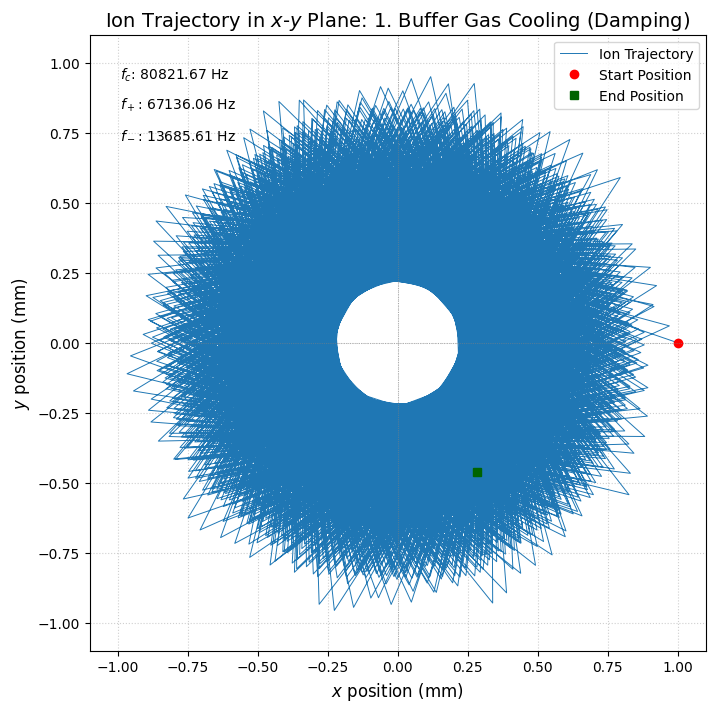

Figures saved as 2_RF_Excitation_at_f_+_(Conversion,_T_2).png and 2_RF_Excitation_at_f_+_(Conversion,_T_2).pdf


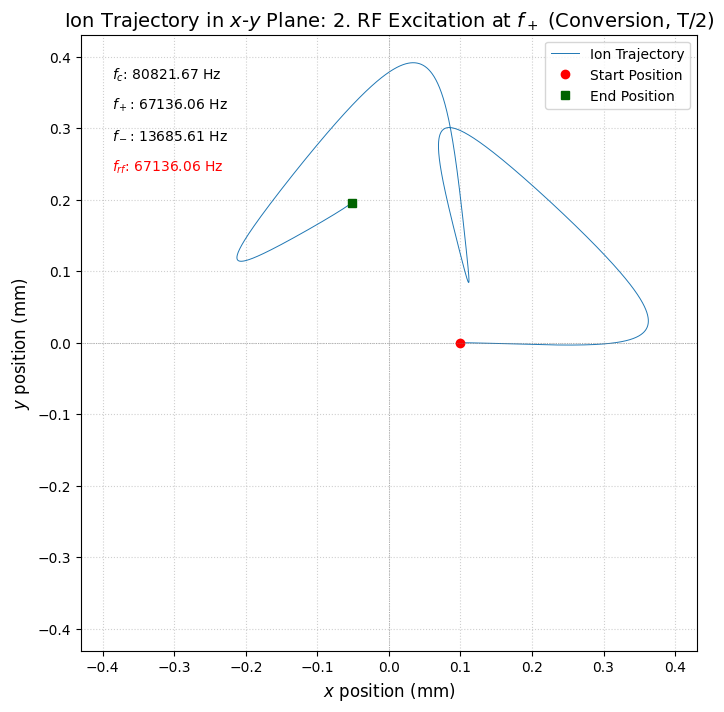

Figures saved as 3_RF_Excitation_at_f_-_(Radius_Increase,_15_T).png and 3_RF_Excitation_at_f_-_(Radius_Increase,_15_T).pdf


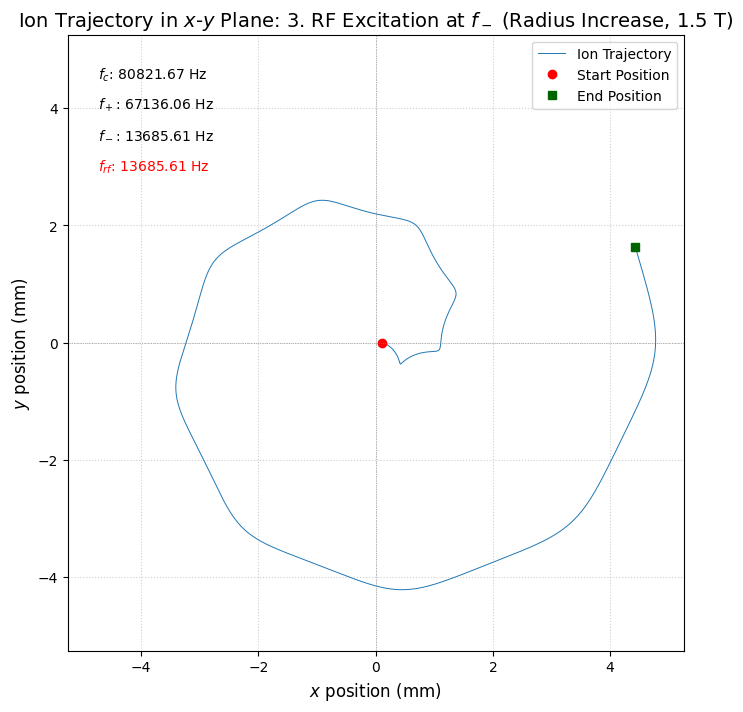

In [1]:
import numpy as np
from scipy.constants import e, physical_constants
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Physical Constants and Parameters ---
def define_parameters(B0_in_T, U0_in_V, d_in_m, ion_mass_u, damping_rate, rf_amplitude_V_m=0.0):
    """
    Defines physical constants, calculates characteristic frequencies,
    and includes the RF amplitude for excitation control.
    """

    # Ion charge (single elementary charge)
    q = e
    # Ion mass
    m = ion_mass_u * physical_constants['atomic mass constant'][0]

    # Static Field Parameters
    B0 = B0_in_T  # Magnetic field strength (Tesla)
    U0 = U0_in_V  # Applied endcap voltage (Volts)
    d = d_in_m    # Characteristic trap dimension (meters)

    # Damping (Buffer Gas Cooling)
    eta = damping_rate  # Damping coefficient (s^-1)

    # Calculate Characteristic Frequencies (SI units, rad/s)

    # True Cyclotron Frequency (no electric field)
    omega_c_true = q * B0 / m
    # Axial Frequency squared
    omega_z_sq = 2 * q * U0 / (m * d**2)

    if omega_c_true**2 < 2 * omega_z_sq:
        # Check for stable confinement
        raise ValueError("Trap is unstable: omega_c_true^2 must be > 2 * omega_z^2")

    # Modified Cyclotron Frequencies (Eigenfrequencies)
    omega_plus = (omega_c_true / 2) + np.sqrt((omega_c_true / 2)**2 - omega_z_sq / 2)
    omega_minus = (omega_c_true / 2) - np.sqrt((omega_c_true / 2)**2 - omega_z_sq / 2)

    return {
        'q': q, 'm': m, 'B0': B0, 'U0': U0, 'd': d,
        'omega_z_sq': omega_z_sq, # <-- FIX: Added this key to the dictionary
        'omega_c_true': omega_c_true, 'omega_plus': omega_plus,
        'omega_minus': omega_minus, 'eta': eta,
        'E_rf_amplitude': rf_amplitude_V_m,
        'omega_rf_dipolar': 0.0
    }

# --- System of Differential Equations ---
def penning_ode(t, Y, params, apply_rf):
    """
    Defines the system of 6 first-order differential equations (ODEs).
    Y = [x, y, z, vx, vy, vz]
    """
    x, y, z, vx, vy, vz = Y

    q = params['q']
    m = params['m']
    B0 = params['B0']
    eta = params['eta']
    # FIX: Use the pre-calculated omega_z_sq from the parameters dictionary
    omega_z_sq = params['omega_z_sq']
    omega_rf = params['omega_rf_dipolar']
    E_rf_amplitude = params['E_rf_amplitude']

    # F_E (Electric)
    F_E_x = -0.5 * m * omega_z_sq * x
    F_E_y = -0.5 * m * omega_z_sq * y
    F_E_z = m * omega_z_sq * z

    # F_B (Lorentz)
    F_B_x = q * (vy * B0)
    F_B_y = q * (-vx * B0)

    # F_D (Damping)
    F_D_x = -m * eta * vx
    F_D_y = -m * eta * vy
    F_D_z = -m * eta * vz

    # F_RF (Excitation) - Azimuthal Dipolar
    F_RF_x, F_RF_y = 0.0, 0.0
    if apply_rf:
        # Rotating electric field
        F_RF_x = q * E_rf_amplitude * np.cos(omega_rf * t)
        F_RF_y = q * E_rf_amplitude * np.sin(omega_rf * t)

    # Acceleration
    ax = (F_E_x + F_B_x + F_D_x + F_RF_x) / m
    ay = (F_E_y + F_B_y + F_D_y + F_RF_y) / m
    az = (F_E_z + F_D_z) / m

    return [vx, vy, vz, ax, ay, az]

# --- Simulation and Plotting Function ---
def simulate_and_plot(scenario_name, params, t_span, initial_state, apply_rf):
    """Runs the simulation, plots the 2D trajectory, and saves the figure."""

    ode_func = lambda t, Y: penning_ode(t, Y, params, apply_rf)

    # Optimization: Using fewer t_eval points and looser rtol for speed
    sol = solve_ivp(
        ode_func,
        t_span,
        initial_state,
        method='RK45',
        rtol=1e-4,
        dense_output=True,
        t_eval=np.linspace(t_span[0], t_span[1], 3000)
    )

    x, y = sol.y[0] * 1e3, sol.y[1] * 1e3 # Convert position to mm for better scale

    # --- Plotting ---
    plt.figure(figsize=(8, 8))
    plt.plot(x, y, label='Ion Trajectory', color='#1f77b4', linewidth=0.7)

    # Mark start and end points
    plt.plot(x[0], y[0], 'o', color='red', markersize=6, label='Start Position')
    plt.plot(x[-1], y[-1], 's', color='darkgreen', markersize=6, label='End Position')

    # Aesthetics
    plt.title(f'Ion Trajectory in $x$-$y$ Plane: {scenario_name}', fontsize=14)
    plt.xlabel('$x$ position (mm)', fontsize=12)
    plt.ylabel('$y$ position (mm)', fontsize=12)

    # Auto-adjust limits for best view
    max_range = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    plt.xlim(-max_range, max_range)
    plt.ylim(-max_range, max_range)

    plt.axhline(0, color='gray', linestyle=':', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle=':', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    # Display key frequencies
    plt.text(0.05, 0.95, f'$f_c$: {params["omega_c_true"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f'$f_+$: {params["omega_plus"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.85, f'$f_-$: {params["omega_minus"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

    if apply_rf:
        plt.text(0.05, 0.80, f'$f_{{rf}}$: {params["omega_rf_dipolar"]/(2*np.pi):.2f} Hz', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color='red')

    # --- Saving Figures ---
    filename_base = scenario_name.split(':')[0].replace(" ", "_").replace("$", "").replace("\\", "").replace("/", "_").replace(".", "")

    plt.savefig(f'{filename_base}.png', dpi=300)
    plt.savefig(f'{filename_base}.pdf')
    print(f"Figures saved as {filename_base}.png and {filename_base}.pdf")

    plt.show()

# --- Main Execution ---
if __name__ == '__main__':

    # Base Parameters (Selected to match visual ratios in paper figures)
    # Cs-133+ (a heavy ion often used in traps)
    ION_MASS_U = 133.0
    B0_T = 0.7  # Magnetic field strength (Tesla)
    U0_V = 5.0  # Applied voltage (Volts)
    D_M = 0.01  # Characteristic trap dimension (meters)

    base_params = define_parameters(B0_T, U0_V, D_M, ION_MASS_U, damping_rate=0.0)

    # Calculate Magnetron Period (T-) for setting simulation times
    T_magnetron = 2 * np.pi / base_params['omega_minus']

    print("--- Calculated Frequencies for Cs-133+ (Base) ---")
    print(f"B0: {B0_T} T, U0: {U0_V} V, Ion Mass: {ION_MASS_U} Da")
    print(f"f_c (True Cyclotron): {base_params['omega_c_true']/(2*np.pi):.2f} Hz")
    print(f"f_z (Axial): {np.sqrt(base_params['omega_z_sq'])/(2*np.pi):.2f} Hz") # FIX: Accesses the new key
    print(f"f_+ (Modified Cyclotron): {base_params['omega_plus']/(2*np.pi):.2f} Hz")
    print(f"f_- (Magnetron): {base_params['omega_minus']/(2*np.pi):.2f} Hz")
    print(f"T_- (Magnetron Period): {T_magnetron:.4f} s")
    print("--------------------------------------------------")

    # Initial State for SCENARIO 1 (Cooling)
    # Start with a large initial displacement (1mm) and zero velocity.
    initial_state_cooling = [1.0e-3, 0.0, 0.0, 0.0, 0.0, 0.0]

    # ----------------------------------------------------
    # SCENARIO 1: Buffer Gas Cooling (Figure 2 Match)
    # Goal: Show multiple periods of magnetron decay towards the center.
    # ----------------------------------------------------
    params_cooling = define_parameters(B0_T, U0_V, D_M, ION_MASS_U, damping_rate=5.0)
    t_span_cooling = [0, 1.0] # ~7 periods of T-

    simulate_and_plot(
        "1. Buffer Gas Cooling (Damping)",
        params_cooling,
        t_span_cooling,
        initial_state_cooling,
        apply_rf=False
    )

    # ----------------------------------------------------
    # SCENARIO 2: Modified Cyclotron Excitation at f+ (Figure 4 Match)
    # Goal: Convert large magnetron radius (r-) into a small, centered orbit (r+).
    # Simulation time set to T_magnetron / 2 to show the conversion spiral clearly.
    # ----------------------------------------------------
    RF_AMPLITUDE_PLUS = 50.0 # V/m
    params_rf_plus = define_parameters(B0_T, U0_V, D_M, ION_MASS_U, damping_rate=0.5, rf_amplitude_V_m=RF_AMPLITUDE_PLUS)
    params_rf_plus['omega_rf_dipolar'] = params_rf_plus['omega_plus'] # Tune to f+

    t_span_rf_plus = [0, T_magnetron / 2]

    # Start with a noticeable magnetron component to convert
    initial_state_rf_plus = [0.1e-3, 0.0, 0.0, 0.0, 0.0, 0.0]

    simulate_and_plot(
        f"2. RF Excitation at $f_+$ (Conversion, T/2)",
        params_rf_plus,
        t_span_rf_plus,
        initial_state_rf_plus,
        apply_rf=True
    )

    # ----------------------------------------------------
    # SCENARIO 3: Magnetron Excitation at f- (Figure 5 Match)
    # Goal: Increase the magnetron radius (r-), spiraling outwards.
    # Simulation time set to T_magnetron * 1.5 to show clear outward growth.
    # ----------------------------------------------------
    RF_AMPLITUDE_MINUS = 50.0 # V/m
    params_rf_minus = define_parameters(B0_T, U0_V, D_M, ION_MASS_U, damping_rate=0.5, rf_amplitude_V_m=RF_AMPLITUDE_MINUS)
    params_rf_minus['omega_rf_dipolar'] = params_rf_minus['omega_minus'] # Tune to f-

    t_span_rf_minus = [0, T_magnetron * 1.5]

    # Start close to center to show outward growth clearly
    initial_state_rf_minus = [0.1e-3, 0.0, 0.0, 0.0, 0.0, 0.0]

    simulate_and_plot(
        f"3. RF Excitation at $f_-$ (Radius Increase, 1.5 T)",
        params_rf_minus,
        t_span_rf_minus,
        initial_state_rf_minus,
        apply_rf=True
    )
